In [31]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [32]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [33]:
def openCSV(filename):
    '''
    Takes in filename string (with position relative to this location)
    Returns dataframe
    '''
    file = pd.read_csv(filename)
    return pd.DataFrame(file)

In [34]:
# Open all the files
dos_df = openCSV("./DoS_dataset.csv")
fuzzy_df = openCSV("./Fuzzy_dataset.csv")
gear_df = openCSV("./gear_dataset.csv")
rpm_df = openCSV("./RPM_dataset.csv")

# DOS
1. Reformat the data to combine the data payload and to equalize the 8bit and 2bit data
2. Encode to matrix of binary
3. Apply KNN

In [35]:
dos_df.head()

,1478198376.389427,0316,8,05,21,68,09,21.1,21.2,00,6f,R
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [36]:
# Add label to the data
dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [37]:
# Splitting the 2 bytes and 8 bytes data
twob_dos_df = dos_df[dos_df["Label"].isnull()]
eightb_dos_df = dos_df[dos_df["Label"].isnull()  == False]

In [38]:
# Combine payload
eightb_dos_df["data"] = eightb_dos_df['[P'] + eightb_dos_df["a"] + eightb_dos_df["Y"] + eightb_dos_df["L"]  + eightb_dos_df["O"]  + eightb_dos_df["A"]  + eightb_dos_df["D"]  + eightb_dos_df["data]"]
eightb_dos_df.head()

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label,data
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R,fe5b0000003c0000
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R,19212230088e6d3a
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R,64009a1d9702bd00
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R,40bb7f1411200014
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R,d800008a00000000


In [39]:
# Clean up unused columns
eightb_dos_df = eightb_dos_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
eightb_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [40]:
# Label and clean up the 2 bytes entries
twob_dos_df = twob_dos_df.dropna(axis='columns')
twob_dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label
35,1.478198e+09,05f0,2,01,00,R
134,1.478198e+09,05f0,2,01,00,R
226,1.478198e+09,05f0,2,01,00,R
319,1.478198e+09,05f0,2,01,00,R
411,1.478198e+09,05f0,2,01,00,R


In [41]:
# Combine payload for 2 bytes entries
twob_dos_df["data"] = twob_dos_df['[Payload'] + twob_dos_df["Data]"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label,data
35,1.478198e+09,05f0,2,01,00,R,0100
134,1.478198e+09,05f0,2,01,00,R,0100
226,1.478198e+09,05f0,2,01,00,R,0100
319,1.478198e+09,05f0,2,01,00,R,0100
411,1.478198e+09,05f0,2,01,00,R,0100


In [42]:
# Clean up unused label 
twob_dos_df = twob_dos_df.drop(columns=['[Payload',"Data]"])
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
35,1.478198e+09,05f0,2,R,0100
134,1.478198e+09,05f0,2,R,0100
226,1.478198e+09,05f0,2,R,0100
319,1.478198e+09,05f0,2,R,0100
411,1.478198e+09,05f0,2,R,0100


In [43]:
# Combine the 8bytes and 2bytes entries together
frames = [eightb_dos_df,twob_dos_df]
dos_formatted = pd.concat(frames)

In [44]:
dos_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [45]:
# Return dataframe to the same order as original based on timestamp
dos_formatted = dos_formatted.sort_values(by=['Timestamp'])
dos_formatted.tail()

,Timestamp,CAN ID,Data size (bytes),Label,data
3665765,1.478201e+09,018f,8,R,fe59000000410000
3665766,1.478201e+09,0260,8,R,18212130088f6d19
3665767,1.478201e+09,02a0,8,R,24009a1d9702bd00
3665768,1.478201e+09,0329,8,R,dcb77f1411200014
3665769,1.478201e+09,0545,8,R,d800008b00000000


# Until here has been reformatting and combining the 2 bytes and 8 bytes data. 

In [46]:
# Convert CAN ID to int representation
dos_formatted['CAN ID'] = [int(x,16) for x in dos_formatted['CAN ID']]
dos_formatted.head()


,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,399,8,R,fe5b0000003c0000
1,1.478198e+09,608,8,R,19212230088e6d3a
2,1.478198e+09,672,8,R,64009a1d9702bd00
3,1.478198e+09,809,8,R,40bb7f1411200014
4,1.478198e+09,1349,8,R,d800008a00000000


In [151]:
# Let's only take 5000 sample
dos_formatted_5k = dos_formatted[:10000]

In [152]:
class MsgData:
    def __init__(self,can_id,time,index):
        self.can_id = can_id
        self.last_occured = time
        self.last_index = index
    
    def updateTime(self,time):
        self.last_occured = time
        
    def updateIndex(self,index):
        self.last_index = index 
        
    def getTimeDiff(self,time):
        return time - self.last_occured
    
    def getIndex(self):
        return self.last_index

In [197]:
'''
id: xxxx
last_occured: <time>
data: []
data_count = x

keep last occured index rather than data
then it can look for the data itself later on
'''
hashtable = {}
time_series = []
data_series = []
data_len_series = []

for index, row in dos_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = dos_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    

In [198]:
print(len(time_series))
print(len(data_series))
print(len(data_len_series))

10000
10000
10000


In [199]:
data_series[1]

array([], dtype=int64)

In [200]:
dos_formatted_5k["Time since"] = time_series
dos_formatted_5k["Data in between"] = data_series
dos_formatted_5k["How many data since last"] = data_len_series

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [201]:
dos_formatted_5k.head(20)
#How many since last = how many data is between the 2 occurence.

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478198e+09,399,8,R,fe5b0000003c0000,0.000000,[],0
1,1.478198e+09,608,8,R,19212230088e6d3a,0.000000,[],0
2,1.478198e+09,672,8,R,64009a1d9702bd00,0.000000,[],0
3,1.478198e+09,809,8,R,40bb7f1411200014,0.000000,[],0
4,1.478198e+09,1349,8,R,d800008a00000000,0.000000,[],0
5,1.478198e+09,2,8,R,0000000000030b11,0.000000,[],0
6,1.478198e+09,339,8,R,002110ff00ff0000,0.000000,[],0
7,1.478198e+09,704,8,R,1400000000000000,0.000000,[],0
8,1.478198e+09,304,8,R,088000ff31800b7f,0.000000,[],0
9,1.478198e+09,305,8,R,e57f0000487f0bac,0.000000,[],0


In [202]:
# Randomize to break locality and then split data to 70:30 
train, test = np.split(dos_formatted_5k.sample(frac=1), [int(.7*len(dos_formatted_5k))])
train.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
9484,1.478198e+09,304,8,R,118000ff2880033a,0.008845,"[305, 320, 809, 880, 1087, 1088, 1349, 704, 84...",11
9302,1.478198e+09,399,8,R,fe5b0000003c0000,0.009990,"[608, 304, 305, 320, 672, 809, 880, 1087, 1088...",17
9486,1.478198e+09,320,8,R,000000002400239c,0.008841,"[809, 880, 1087, 1088, 1349, 704, 848, 2, 339,...",11
136,1.478198e+09,1201,8,R,292727230000009a,0.019990,"[497, 339, 2, 704, 848, 304, 305, 320, 880, 10...",36
4955,1.478198e+09,0,8,T,0000000000000000,0.000491,[304],1


In [203]:
print(train.shape)
print(test.shape)

(7000, 8)
(3000, 8)


In [204]:
def createIntLabel(df):
    '''
    Input is df
    Output 0/1 version of the label
    '''
    int_label = []
    for x in df['Label']:
        if x == True:
            int_label.append(1)
        else:
            int_label.append(0)
    return int_label

In [205]:
def binary(x):
    if x == "T":
        return 1
    return 0

In [206]:
# Prepare data for 
train_label = [binary(x) for x in train['Label']]
train_data = train.drop(columns="Label")
test_label = [binary(x) for x in test['Label']]
test_data = test.drop(columns="Label")

In [207]:
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_train_data = train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_train_data = simplified_train_data.set_index("CAN ID")
simplified_train_data.head()

,Time since
CAN ID,
304,0.008845
399,0.009990
320,0.008841
1201,0.019990
0,0.000491


In [208]:
simplified_test_data = test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_test_data = simplified_test_data.set_index("CAN ID")
simplified_test_data.head()

,Time since
CAN ID,
339,0.009506
608,0.031379
0,0.000500
809,0.009860
809,0.009619


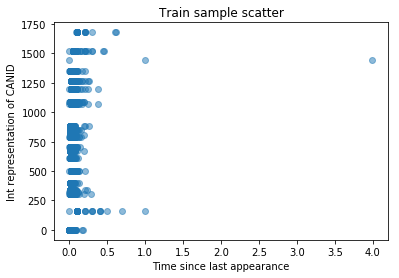

In [209]:
import matplotlib.pyplot as plt 
plt.scatter(simplified_train_data["Time since"], simplified_train_data.index,alpha=0.5)
plt.title('Train sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

In [210]:
simplified_train_data.shape
len(train_label)

7000

In [211]:
if 1 in train_label:
    print("aye")

aye


In [212]:
train_label

[0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,


In [213]:
#Let's try...KNN (it should be able to detect DOS)
classifier = KNeighborsClassifier(n_neighbors = 20)
classifier.fit(simplified_train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [214]:
guesses = classifier.predict(simplified_test_data)
guesses

array([0, 0, 1, ..., 0, 1, 1])

In [215]:
classifier.score(simplified_test_data,test_label)

0.9836666666666667

In [216]:
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))

Accuracy: 0.9836666666666667
Recall: 0.9601063829787234
Precision: 0.9963201471941122
F1: 0.9778781038374718


In [170]:
for ori, guess in zip(test_label,guesses):
    if ori != guess:
        print("huh")

In [23]:
# new_strain_data = pd.get_dummies(simplified_train_data)
# new_strain_data

In [24]:
#Encode string data to integer 
le = LabelEncoder()
train_data = simplified_train_data.apply(le.fit_transform)
test_data = simplified_test_data.apply(le.fit_transform)
train_data.head()

,data
CAN ID,
04f0,1362
0153,1366
02a0,46294
0440,59885
0000,0


In [25]:
#Encode data to matrix of integers
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_data)
train_data = enc.transform(train_data).toarray()

In [26]:
train_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
#it killed the kernel now
enc.fit(test_data)
test_data = enc.transform(test_data).toarray()

In [28]:
test_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
#Let's try...KNN (it should be able to detect DOS)
classifier = KNeighborsClassifier(n_neighbors = 5)
start_time = time.time()
classifier.fit(train_data,train_label)
elapsed_time = time.time() - start_time

ValueError: setting an array element with a sequence.

In [ ]:
#Kernel died
new_train_data = pd.get_dummies(train_data)
new_train_data

In [30]:
# Encode string data to integer 
# le = LabelEncoder()
# train_data = train_data.apply(le.fit_transform)
# test_data = test_data.apply(le.fit_transform)
# train_data.head()

,Timestamp,CAN ID,Data size (bytes),data
743482,520021,0,1,0
68311,47729,12,1,25661
1051654,736072,18,1,1680
698067,488223,5,1,14627
2178975,1524919,0,1,0


In [31]:
# Encode data to matrix of integers
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(test_data)
# test_data = enc.transform(test_data).toarray()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
enc.fit(train_data)
train_data = enc.transform(train_data).toarray()

In [28]:
#Let's try...KNN (it should be able to detect DOS)
classifier = KNeighborsClassifier(n_neighbors = 5)
start_time = time.time()
classifier.fit(train_data,train_label)
elapsed_time = time.time() - start_time

TypeError: float() argument must be a string or a number, not 'OneHotEncoder'

In [ ]:
elapsed_time

In [ ]:
guesses = classifier.predict(test_data)
guesses

In [ ]:
classifier.score(test_data,test_label)

In [176]:
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))

Accuracy: 0.8864840583742751
Recall: 0.406304163126593
Precision: 0.7818054995476987
F1: 0.5347163468168451


In [17]:
fuzzy_df.head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R


In [67]:
fuzzy_df[fuzzy_df['R'] == "T"].head(10)

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
1566,1.478196e+09,00df,8,8c,ab,f2,26,7a,29,1a,0c,T
1567,1.478196e+09,06ea,8,25,10,9c,ed,5b,16,2c,18,T
1568,1.478196e+09,02fd,8,3f,bd,68,f3,c3,4f,28,d4,T
1575,1.478196e+09,012d,8,35,45,99,cf,09,80,c7,77,T
1579,1.478196e+09,033a,8,1c,04,86,90,7f,08,7e,c9,T
1583,1.478196e+09,039f,8,0e,2c,1c,49,e7,58,f6,6d,T
1585,1.478196e+09,07e3,8,7e,67,f3,ce,18,db,45,23,T
1587,1.478196e+09,0491,8,57,b5,20,cc,ad,83,d4,ef,T
1588,1.478196e+09,0522,8,04,72,b8,73,8c,bc,1a,79,T
1589,1.478196e+09,02fd,8,02,fd,0b,1b,94,54,94,54,T


In [62]:
fuzzy_df[fuzzy_df['R'].isnull()].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
18,1.478196e+09,02b0,5,ff,7f,00,05,7a,R,NaN,NaN,NaN
41,1.478196e+09,02b0,5,ff,7f,00,05,6b,R,NaN,NaN,NaN
59,1.478196e+09,02b0,5,ff,7f,00,05,1c,R,NaN,NaN,NaN
79,1.478196e+09,05f0,2,00,00,R,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
fuzzy_df[fuzzy_df['00.3'] == "T"].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R


In [66]:
fuzzy_df[fuzzy_df['00.1'] == "T"].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R


In [18]:
gear_df.head()

,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
0,1.478193e+09,02c0,8,15,00,00,00,00,00,00,00,R
1,1.478193e+09,0350,8,05,20,44,68,77,00,00,7e,R
2,1.478193e+09,0370,8,00,20,00,00,00,00,00,00,R
3,1.478193e+09,043f,8,10,40,60,ff,78,c4,08,00,R
4,1.478193e+09,0440,8,ff,00,00,00,ff,c4,08,00,R


In [58]:
gear_df[gear_df['R'] == "T"].head()

,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
2139,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2140,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2141,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2143,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2149,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T


In [19]:
rpm_df.head()

,1478191030.045114,0316,8,05,22,68,09,22.1,20,00,75,R
0,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,00,R
1,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,3f,R
2,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,00,R
3,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,14,R
4,1.478191e+09,0545,8,d8,00,00,83,00,00,00,00,R


In [59]:
rpm_df[rpm_df['R'] == "T"].head()

,1478191030.045114,0316,8,05,22,68,09,22.1,20,00,75,R
1707,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1710,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1711,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1712,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1715,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
